# Set Variables

In [1]:
top_k = 20

# α (alpha: bug_localization_accuracy)
bug_localization_accuracy = [0.4, 0.5, 0.6, 0.7, 0.8]

# ϴ (theta: knn_accuracy_threshold)
knn_accuracy_threshold = [ 
    0.5, 0.55, 
    0.6, 0.65, 
    0.7, 0.75, 
    0.8, 0.85, 
    0.9, 0.95
]

# β (beta: predictable classes)
class_percentage = 0.5

# th1 (classes with label 1)
label1_th = 0.5

# -------- outp_version
output_version = 1092

# -------- dataset
# software_name = "Camel"
# software_name = "CloudStack"
# software_name = "Geode"
software_name = "Hbase"

In [2]:
print("bla: ", bug_localization_accuracy)
print("th:  ", knn_accuracy_threshold)

bla:  [0.4, 0.5, 0.6, 0.7, 0.8]
th:   [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


In [3]:
if software_name == "Camel":
    dataset_file_name =    "Camel_Bugs - v.01"
    
elif software_name == "CloudStack":
    dataset_file_name =    "CloudStack_Bugs - v.01"
    
elif software_name == "Geode":
    dataset_file_name =    "Geode_Bug - v.01"
    
else:
    dataset_file_name =    "Hbase_Bugs - v.03"

# Google Colab

In [4]:
!pip install enlighten
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# load data from google drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
!ls "/content/gdrive/My Drive/"

Mounted at /content/gdrive
'Colab Notebooks'


In [6]:
# project folder path
project_folder = "gdrive/MyDrive/Colab Notebooks/paper/"

# data folder path
data_folder = "00- My Data/two-phased method/"

# dataset folder path
dataset_folder = software_name + "/"

# output folder path
output_folder = "01- Jupyter Notebook/two-phased method/00. Output/"

# Libs

In [7]:
import random 
import json
import math
import os

import enlighten
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import truediv
import seaborn as sns

# Config

In [8]:
mypaths = {
    "data": {
        "dataset_bugs":          project_folder + data_folder   + dataset_folder + dataset_file_name + ".csv",
        "dataset_bugs_bla_pred": project_folder + data_folder   + dataset_folder + "top-k/k={}/bla={}/" + "{} _ k={}, bla={} _ pred.csv",
    },
    "output": {
        "performance":            project_folder + output_folder + dataset_folder + dataset_file_name + "/top-k/k={}/performance-v{}.json"
    }
}

preprocessing_params = {
    "data": {
        "dataset_bugs": {
            # time_stamp is the time that we change the class for a bug fixing.
            # id stands for identifier
            "columns_name":   ["bug_report_id", "class_id", "time_stamp", "label"],
            "columns_dtype" : {0: "int64", 1: "int64", 2: "int64", 3:"int32"}
        },
        "dataset_bugs_bla_pred": {
            # time_stamp is the time that we change the class for a bug fixing.
            # id stands for identifier
            "columns_name":   ["bug_report_id", "class_id", "time_stamp", "label"],
            "columns_dtype" : {0: "int64", 1: "int64", 2: "int64", 3:"int32"}
        },
    },
    
    # 0: no change | 1: increase bad smell | -1: decrease bad smell
    "class_labels": [0, 1, -1], 
    "num_classes": 3,
    "bc2_labels": [0, 1],
    "bc2_num_classes": 2,
    "top_k": top_k,
    "class_percentage": class_percentage,
    "label1_th": label1_th,
}

knn_model_params = {
    "train_size": 0.8,
    "n_neighbors": 5
}

progress_colours = ["webmaroon", "salmon", "orangered", "deeppink3", "crimson", 
                    "black", "blue", "gray", "cyan4", "darkgreen"]

In [9]:
print(mypaths["data"]["dataset_bugs_bla_pred"])
print(mypaths["output"]["performance"])

gdrive/MyDrive/Colab Notebooks/paper/00- My Data/two-phased method/Hbase/top-k/k={}/bla={}/{} _ k={}, bla={} _ pred.csv
gdrive/MyDrive/Colab Notebooks/paper/01- Jupyter Notebook/two-phased method/00. Output/Hbase/Hbase_Bugs - v.03/top-k/k={}/performance-v{}.json


In [10]:
mypaths["data"]["dataset_bugs_bla_pred"] = mypaths["data"]["dataset_bugs_bla_pred"].format(
    top_k,
    "{}", # bla
    dataset_file_name,
    top_k,
    "{}" # bla
)

In [11]:
mypaths["output"]["performance"] = mypaths["output"]["performance"].format(
    top_k,
    output_version
)

In [12]:
print(mypaths["data"]["dataset_bugs_bla_pred"])
print(mypaths["output"]["performance"])

gdrive/MyDrive/Colab Notebooks/paper/00- My Data/two-phased method/Hbase/top-k/k=20/bla={}/Hbase_Bugs - v.03 _ k=20, bla={} _ pred.csv
gdrive/MyDrive/Colab Notebooks/paper/01- Jupyter Notebook/two-phased method/00. Output/Hbase/Hbase_Bugs - v.03/top-k/k=20/performance-v1092.json


# Read Files

## df_main

In [13]:
df_main = pd.read_csv(
    mypaths["data"]["dataset_bugs"], 
    names=preprocessing_params["data"]["dataset_bugs"]["columns_name"], 
    dtype=preprocessing_params["data"]["dataset_bugs"]["columns_dtype"], 
    header=None
)

## df_data_pred_empty

In [14]:
pred_col_name = []
pred_col_name.extend(preprocessing_params["data"]["dataset_bugs_bla_pred"]["columns_name"])
pred_col_type = {}
pred_col_type.update(preprocessing_params["data"]["dataset_bugs_bla_pred"]["columns_dtype"])
count = len(pred_col_type)
for th in knn_accuracy_threshold:
    temp1 = "predictions_" + str(th)
    pred_col_name.append(temp1)
    pred_col_type[count] = pd.Int32Dtype()
    count += 1

In [15]:
pred_col_type

{0: 'int64',
 1: 'int64',
 2: 'int64',
 3: 'int32',
 4: Int32Dtype(),
 5: Int32Dtype(),
 6: Int32Dtype(),
 7: Int32Dtype(),
 8: Int32Dtype(),
 9: Int32Dtype(),
 10: Int32Dtype(),
 11: Int32Dtype(),
 12: Int32Dtype(),
 13: Int32Dtype()}

In [16]:
print(len(pred_col_name))
pred_col_name

14


['bug_report_id',
 'class_id',
 'time_stamp',
 'label',
 'predictions_0.5',
 'predictions_0.55',
 'predictions_0.6',
 'predictions_0.65',
 'predictions_0.7',
 'predictions_0.75',
 'predictions_0.8',
 'predictions_0.85',
 'predictions_0.9',
 'predictions_0.95']

## df_data_pred

In [17]:
df_data_pred = {}

for bla in bug_localization_accuracy:
    print("*" * 10, bla)
    full_path = mypaths["data"]["dataset_bugs_bla_pred"].format(
        bla,
        bla
    )
    print(full_path)
    print(os.path.isfile(full_path))
    df_data_pred[bla] = pd.read_csv(
        full_path, 
        dtype=pred_col_type
    )

********** 0.4
gdrive/MyDrive/Colab Notebooks/paper/00- My Data/two-phased method/Hbase/top-k/k=20/bla=0.4/Hbase_Bugs - v.03 _ k=20, bla=0.4 _ pred.csv
True
********** 0.5
gdrive/MyDrive/Colab Notebooks/paper/00- My Data/two-phased method/Hbase/top-k/k=20/bla=0.5/Hbase_Bugs - v.03 _ k=20, bla=0.5 _ pred.csv
True
********** 0.6
gdrive/MyDrive/Colab Notebooks/paper/00- My Data/two-phased method/Hbase/top-k/k=20/bla=0.6/Hbase_Bugs - v.03 _ k=20, bla=0.6 _ pred.csv
True
********** 0.7
gdrive/MyDrive/Colab Notebooks/paper/00- My Data/two-phased method/Hbase/top-k/k=20/bla=0.7/Hbase_Bugs - v.03 _ k=20, bla=0.7 _ pred.csv
True
********** 0.8
gdrive/MyDrive/Colab Notebooks/paper/00- My Data/two-phased method/Hbase/top-k/k=20/bla=0.8/Hbase_Bugs - v.03 _ k=20, bla=0.8 _ pred.csv
True


In [18]:
df_data_pred

{0.4:        bug_report_id  class_id  time_stamp  label  predictions_0.5  \
 0              41737    127912  1583149803      0             <NA>   
 1              41737    125458  1583149803      0             <NA>   
 2              41737    120384  1583149803      0             <NA>   
 3              41737    128410  1583149803      0                0   
 4              41737    125502  1583149803      0             <NA>   
 ...              ...       ...         ...    ...              ...   
 43822          53953    130964  1285307201      0             <NA>   
 43823          53953    131325  1285307201      0             <NA>   
 43824          53953    131110  1285307201      0             <NA>   
 43825          53953    131286  1285307201      0             <NA>   
 43826          53953    130678  1285307201      0             <NA>   
 
        predictions_0.55  predictions_0.6  predictions_0.65  predictions_0.7  \
 0                  <NA>             <NA>              <NA>  

In [19]:
dfg_brIDs = df_main.groupby("bug_report_id") # brIDs: bug report ids
brIDs_num = len(dfg_brIDs) # number of bug reports
brIDs_num

9201

# DataAfterTimeSerPrediction

In [20]:
class DataAfterTimeSerPrediction:
    def __init__(self, df_data_pred, class_percentage, bug_localization_accuracy, threshold):
        self.class_percentage = class_percentage
        self.df_data_pred_ = df_data_pred
        self.df_data_pred_filtered = {}
        
        self.bla = bug_localization_accuracy
        self.threshold = threshold
    
    
    # ************************** progress lines ************************** #
    
    def progress_lines(self, colours):
        desc = self.set_strings_to_equal_len_()
        total = len(self.threshold)
        manager = enlighten.get_manager()
        progresses = {}
        for i, bla in enumerate(self.bla):
            prog = manager.counter(total=total, desc=desc[i], unit="sample", color=colours[i])
            prog.refresh()
            progresses[bla] = prog
        self.progresses = progresses
    
    
    def set_strings_to_equal_len_(self):
        words = []
        for bla in self.bla:
            desc = "filter-bla-" + str(bla)
            words.append(desc)
        
        max_len = 0
        longest_string_length = len(max(words, key=len))
        w = []
        for i, word in enumerate(words):
            temp = longest_string_length - len(word)
            w.append(word + " " * temp)
        return w
    
    
    # ************************** filter_data ************************** #
    
    def filter_data(self):
        for bla in self.bla:
            #print("*" * 10, bla)
            self.df_data_pred_filtered[bla] = []
            for j, th in enumerate(self.threshold):
                #print(th)
                mydf = self.df_notna_base_prediction_th_column_(bla, th)
                tempdf = mydf.groupby("bug_report_id")
                tempdf.apply(lambda g: self.sub_1(g, mydf))
                # ----
                tempColumnName = self.prediction_column_name_(th)
                mydf = mydf[mydf[tempColumnName].notna()]
                self.df_data_pred_filtered[bla].append(mydf)
                self.progresses[bla].update()
    
    
    def df_notna_base_prediction_th_column_(self, bla, th):
        tempColumnName = self.prediction_column_name_(th)
        final_table_columns = ["bug_report_id", "label"] # ["bug_report_id", "label", "predictions_?"]
        final_table_columns.append(tempColumnName)
        
        tempDF = self.df_data_pred_[bla].copy()
        tempDF = tempDF[tempDF.columns.intersection(final_table_columns)]
        return tempDF
    
    
    def sub_1(self, g, mydf):
        numNan = g.iloc[:, -1].isna().sum()
        numPredictable = len(g) - numNan
        # ----
        temp3 = numPredictable / len(g)
        if temp3 < self.class_percentage:
            mydf.drop(g.index, inplace=True)
    
    
    def prediction_column_name_(self, th):
        return "predictions_" + str(th)
    
    
    def free_memory(self):
        self.df_data_pred_ = None

## obj

In [21]:
datp_data = DataAfterTimeSerPrediction(
    df_data_pred, 
    preprocessing_params["class_percentage"], 
    bug_localization_accuracy, 
    knn_accuracy_threshold
)

datp_data.progress_lines(progress_colours)

datp_data.filter_data()

datp_data.free_memory()

In [22]:
my_temp_100 = None
if knn_accuracy_threshold[0] == 1:
    my_temp_100 = datp_data.df_data_pred_filtered[1][0] # main data
else:
    print("else")
    if bug_localization_accuracy[0] == 1:
        print("bla = 1")
        my_temp_100 = datp_data.df_data_pred_filtered[1][0]
    else:
        print("bla != 1")
        my_temp_100 = datp_data.df_data_pred_filtered[0.4][0]

my_temp_100

else
bla != 1


,bug_report_id,label,predictions_0.5
89,41778,1,-1
167,41808,0,0
168,41808,0,0
172,41808,-1,0
173,41808,-1,0
...,...,...,...
43547,53786,0,0
43607,53831,0,0
43613,53841,1,0
43631,53854,-1,0


In [23]:
datp_data.df_data_pred_filtered

{0.4: [       bug_report_id  label  predictions_0.5
  89             41778      1               -1
  167            41808      0                0
  168            41808      0                0
  172            41808     -1                0
  173            41808     -1                0
  ...              ...    ...              ...
  43547          53786      0                0
  43607          53831      0                0
  43613          53841      1                0
  43631          53854     -1                0
  43638          53862      1                1
  
  [5801 rows x 3 columns],        bug_report_id  label  predictions_0.55
  89             41778      1                -1
  167            41808      0                 0
  168            41808      0                 0
  172            41808     -1                 0
  173            41808     -1                 0
  ...              ...    ...               ...
  43547          53786      0                 0
  43607          53

# BugClassSpecifying

In [24]:
class BugClassSpecifying():
    
    def __init__(self, df, l1_th):
        # df: DataFrame("bug_report_id", "label|prediction_th")
        
        self.gdf = df.groupby("bug_report_id")
        self.l1_th = l1_th
        
        # df_bug_pred
        columns_name = ["bug_report_id", "bug_class_2"]
        columns_dtype = ["int64", "int32"]
        temp = {}
        for cn, cd in zip(columns_name, columns_dtype):
                temp[cn] = pd.Series(dtype=cd)
        self.df_bug_pred = pd.DataFrame(temp)
        self.df_bug_pred["bug_report_id"] = self.gdf.groups.keys()
        self.df_bug_pred["bug_class_2"] = self.df_bug_pred["bug_class_2"].astype("Int32")
    
    
    # =============================================
    #                   bug class
    # =============================================
    
    def bug_class(self):
        self.gdf.apply(lambda g: self.sub_bug_class_(g))
    
    
    def sub_bug_class_(self, g):
        # --------- bc_2: {1, 0}
        bc = None
        label_column = g.iloc[:, -1].to_list()
        label_column_num_ones = label_column.count(1)
        # ----
        temp3 = label_column_num_ones / len(label_column)
        bc = 1 if temp3 >= self.l1_th else 0
        self.df_bug_pred.loc[(self.df_bug_pred["bug_report_id"] == g.name), "bug_class_2"] = bc
    
    
    def free_memory(self):
        self.gdf = None

## obj

In [25]:
df_main_bug_preds_obj = BugClassSpecifying(df_main.copy(), preprocessing_params["label1_th"])
df_main_bug_preds_obj.bug_class()
df_main_bug_preds_obj.free_memory()
df_main_bug_preds = df_main_bug_preds_obj.df_bug_pred
df_main_bug_preds

,bug_report_id,bug_class_2
0,41737,0
1,41748,0
2,41751,1
3,41754,0
4,41757,0
...,...,...
9196,53949,0
9197,53950,0
9198,53951,0
9199,53952,0


# BugPredictionForData

In [26]:
class BugClassSpecifyingForData():
    def __init__(self, threshold, bug_localization_accuracy):
        self.df_data_bug_preds = {} # {"bla": [data_bug_th1, data_bug_th2, ...], ...}
        
        self.threshold = threshold
        self.bla = bug_localization_accuracy
    
    
    # ************************** progress lines ************************** #
    
    def progress_lines(self, colours):
        desc = self.set_strings_to_equal_len_()
        total = len(self.threshold)
        manager = enlighten.get_manager()
        progresses = []
        for i, bla in enumerate(self.bla):
            prog = manager.counter(total=total, desc=desc[i], unit="sample", color=colours[i])
            prog.refresh()
            progresses.append(prog)
        self.progresses = progresses
    
    
    def set_strings_to_equal_len_(self):
        words = []
        for bla in self.bla:
            desc = "bug-prediction-" + str(bla)
            words.append(desc)
        
        max_len = 0
        longest_string_length = len(max(words, key=len))
        w = []
        for i, word in enumerate(words):
            temp = longest_string_length - len(word)
            w.append(word + " " * temp)
        return w
    
    
    # ************************** make_bug_prediction ************************** #
    
    def make_bug_prediction(self, df_data_pred_filtered, l1_th):
        
        # df_data_bug_preds
        for i, bla in enumerate(self.bla):
            self.df_data_bug_preds[bla] = []
            for j, th in enumerate(self.threshold):
                tempBP = BugClassSpecifying(df_data_pred_filtered[bla][j], l1_th)
                tempBP.bug_class()
                self.df_data_bug_preds[bla].append(tempBP.df_bug_pred)
                self.progresses[i].update()

## obj

In [27]:
bpfd_data = BugClassSpecifyingForData(
    knn_accuracy_threshold, 
    bug_localization_accuracy)

bpfd_data.progress_lines(progress_colours)
bpfd_data.make_bug_prediction(datp_data.df_data_pred_filtered, preprocessing_params["label1_th"])

In [28]:
bpfd_data.df_data_bug_preds

{0.4: [      bug_report_id  bug_class_2
  0             41778            0
  1             41802            0
  2             41805            0
  3             41808            0
  4             41814            0
  ...             ...          ...
  2124          53786            1
  2125          53831            0
  2126          53841            0
  2127          53854            0
  2128          53862            1
  
  [2129 rows x 2 columns],       bug_report_id  bug_class_2
  0             41778            0
  1             41802            0
  2             41805            0
  3             41808            0
  4             41818            0
  ...             ...          ...
  1976          53786            1
  1977          53831            0
  1978          53841            0
  1979          53854            0
  1980          53862            1
  
  [1981 rows x 2 columns],       bug_report_id  bug_class_2
  0             41778            0
  1             41802        

In [29]:
for i in bpfd_data.df_data_bug_preds:
    for j in bpfd_data.df_data_bug_preds[i]:
        print(len(j))

2129
1981
1720
1543
1333
1137
1007
900
763
646
2424
2250
1953
1749
1490
1253
1084
939
791
640
2505
2302
1928
1731
1447
1225
1041
913
762
629
2814
2563
2158
1913
1583
1309
1107
947
784
660
3043
2766
2324
2047
1688
1394
1173
1001
819
660


In [30]:
len(bpfd_data.df_data_bug_preds)

5

# ClassDistribution

In [31]:
class ClassDistribution:
    
    def __init__(self, df_bug_pred):
        self.df_bug_pred = df_bug_pred
        self.my_bug_classes = ["bug_class_2"]
        self.bug_label_num = {}
        self.bug_label_per = {}
        self.bug_label_ratio = {}
        
        for i, bug_class in enumerate(self.my_bug_classes):
            if i == 0: # bug_label_2
                self.bug_label_num[bug_class] =   {"0": 0, "1":  0}
                self.bug_label_per[bug_class] =   {"0": 0, "1":  0}
                self.bug_label_ratio[bug_class] = {}
        
        # plot values
        self.colours = ["red", "blue", "green", "cyan"]
    
    
    # --------------------------- calc_bug_label_num
    
    def calc_bug_label_num_per(self):
        self.df_bug_pred.groupby("bug_class_2").apply(lambda g: self.sub_bln_(g, "bug_class_2"))
    
    
    def sub_bln_(self, g, gby):
        self.bug_label_num[gby][str(g.name)] = len(g)
        self.bug_label_per[gby][str(g.name)] = (len(g) / len(self.df_bug_pred)) * 100
    
    
    # --------------------------- calc_ratios
    
    def calc_bug_label_ratios(self):
        
        for bug_class in self.my_bug_classes:
            temp = self.bug_label_num[bug_class]
            mydata_sorted = [(key, value) for key, value in sorted(temp.items(), 
                                                                   key=lambda item: item[1], reverse=True)]
        
            num_classes = len(temp)
            for i in range(num_classes - 1):
                for j in range(i + 1, num_classes):
                    tempKey1 = mydata_sorted[i][0]
                    tempKey2 = mydata_sorted[j][0]
                    mykey = tempKey1 + "/" + tempKey2

                    tempValue1 = mydata_sorted[i][1]
                    tempValue2 = mydata_sorted[j][1]
                    if tempValue2 != 0:
                        self.bug_label_ratio[bug_class][mykey] = tempValue1 / tempValue2
    
    
    # --------------------------- bar plot
    
    def plot_percent_num(self, bla, th, num_bugs):
        # figsize=(a, b) : a_width, b_height
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        width = 0.2
        my_x = [-0.3, -0.1, 0.1, 0.3]
        
        temp1 = str(num_bugs)
        temp2 = len(temp1) - 1
        temp3 = "1" + "0" * temp2
        temp4 = temp1[0] + "0" * temp2
        temp5 = int(temp3) + int(temp4)
        
        ml = list( range(0, temp5, int(temp3)) )
        ml.append(num_bugs)
        
        for i, key in enumerate(self.my_bug_classes):
            ax1 = axes[0]
            ax2 = axes[1]
            for j, cl in enumerate(self.bug_label_per[key]):
                ax1.bar(my_x[j], self.bug_label_num[key][cl], width=width, label=cl, color=self.colours[j])
                ax2.bar(my_x[j], self.bug_label_per[key][cl], width=width, label=cl, color=self.colours[j])
            
            tempXlabel = "{}".format(key)
            ax1.set_xlabel(tempXlabel)
            ax2.set_xlabel(tempXlabel)
            
            ax1.set_ylabel("Number of Bug Reports")
            ax2.set_ylabel("Percentages (%)")
            
            tempXlim = [-0.5, 0.5]
            ax1.set_xlim(tempXlim)
            ax2.set_xlim(tempXlim)
            
            
            ax1.set_ylim([0, temp5])
            ax2.set_ylim([0, 110])
            
            
            ax1.get_xaxis().set_ticks([])
            ax2.get_xaxis().set_ticks([])
            
            
            ax1.get_yaxis().set_ticks(ml)
            ax2.get_yaxis().set_ticks(list(range(0, 101, 10)))
            
            ax1.legend()
            ax2.legend()
            
            ax1.grid(axis="y")
            ax2.grid(axis="y")
        
        fig.suptitle("bla: {}, th: {}".format(bla, th), fontsize=16)
        fig.tight_layout(pad=3.0)
    
    
    def free_memory(self):
        self.df_bug_pred = None

# ClassDistributionForData

In [32]:
class ClassDistributionForData():
    def __init__(self, threshold, bug_localization_accuracy):
        self.bla = bug_localization_accuracy
        self.threshold = threshold
        
        self.df_data_bug_class_distribution = {}
        for bla in self.bla:
            self.df_data_bug_class_distribution[bla] = {}
            for th in self.threshold:
                self.df_data_bug_class_distribution[bla][th] = {
                    "bug_class_num": None,
                    "bug_class_per": None,
                    "bug_class_ratio": None
                }
    
    
    def plotm(self, df_main_bug_preds, df_data_bug_preds):
        # df_data_bug_plot
        for i, bla in enumerate(self.bla):
            for j, th in enumerate(self.threshold):
                #print(j)
                temp1 = df_data_bug_preds[bla][j]
                temp1_brid = temp1["bug_report_id"].to_list()
                temp2 = df_main_bug_preds[df_main_bug_preds["bug_report_id"].isin(temp1_brid)]
                
                tempBP = ClassDistribution(temp2.copy())
                tempBP.calc_bug_label_num_per()
                tempBP.calc_bug_label_ratios()
                tempBP.plot_percent_num(bla, th, len(temp2))
                tempBP.free_memory()
                
                self.df_data_bug_class_distribution[bla][th]["bug_class_num"] = tempBP.bug_label_num
                self.df_data_bug_class_distribution[bla][th]["bug_class_per"] = tempBP.bug_label_per
                self.df_data_bug_class_distribution[bla][th]["bug_class_ratio"] = tempBP.bug_label_ratio

## obj

In [33]:
cddd = ClassDistributionForData(
    knn_accuracy_threshold, 
    bug_localization_accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


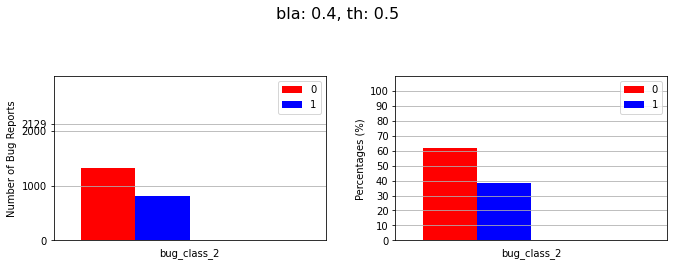

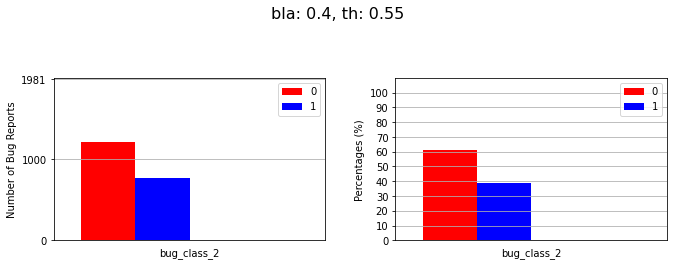

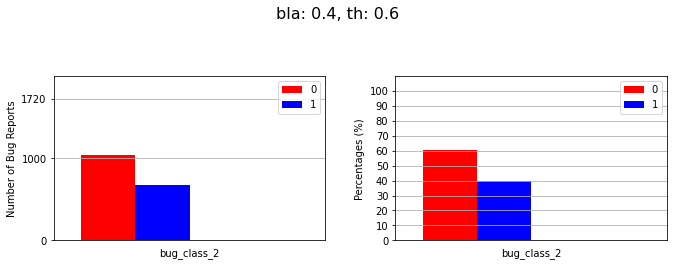

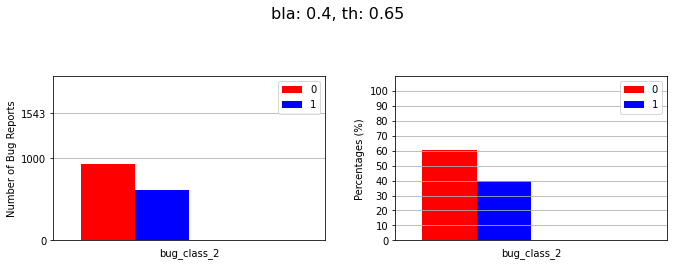

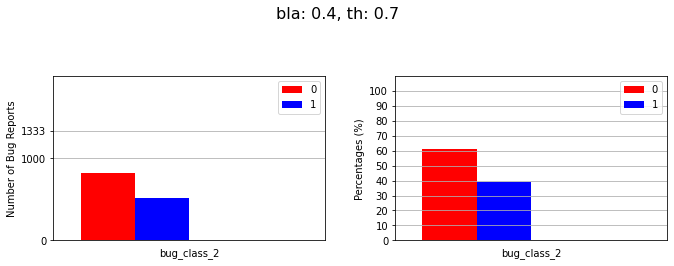

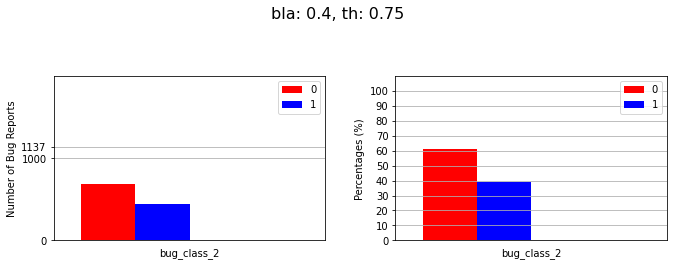

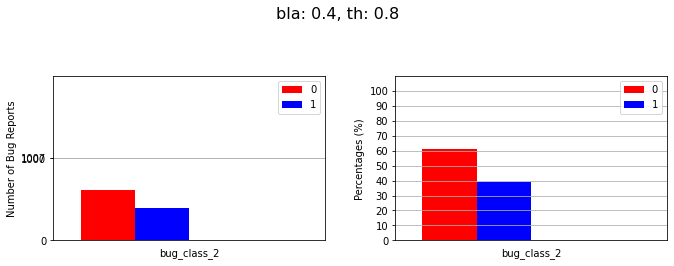

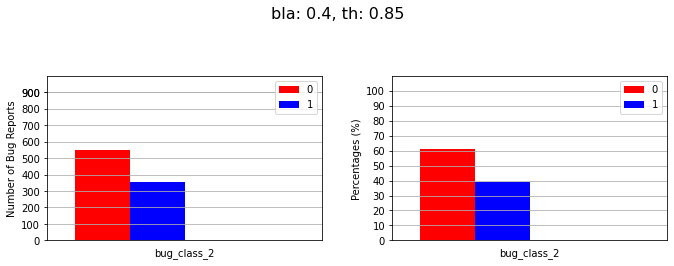

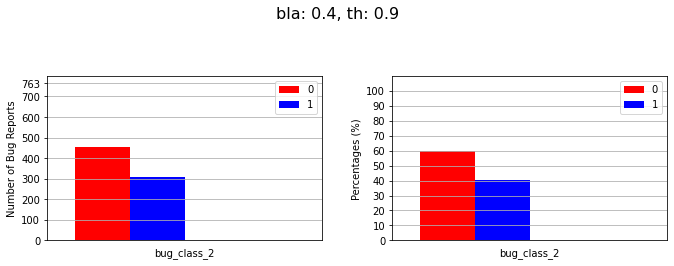

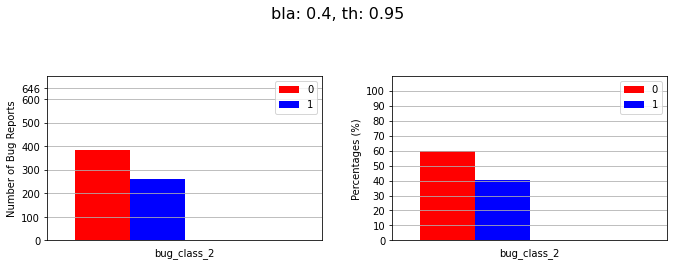

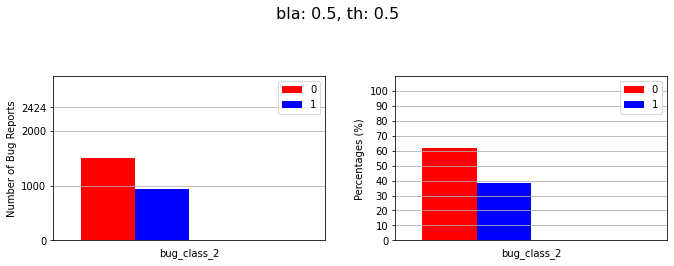

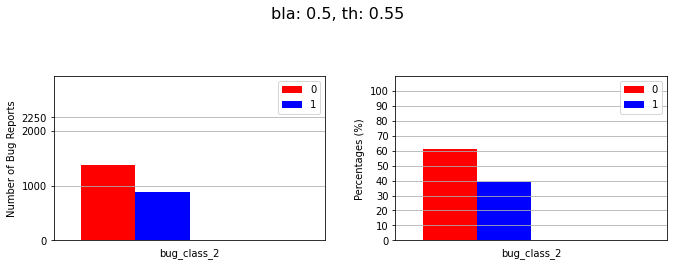

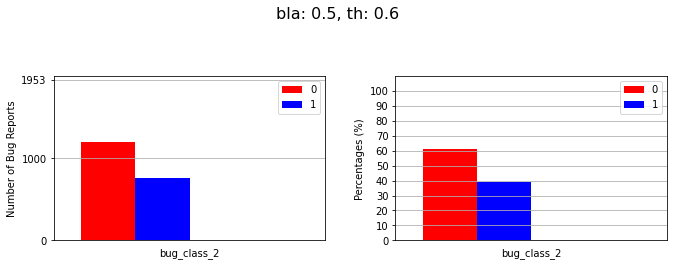

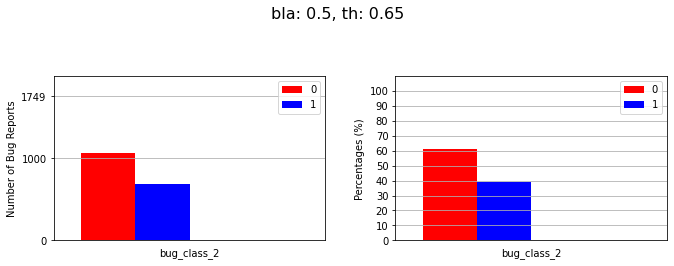

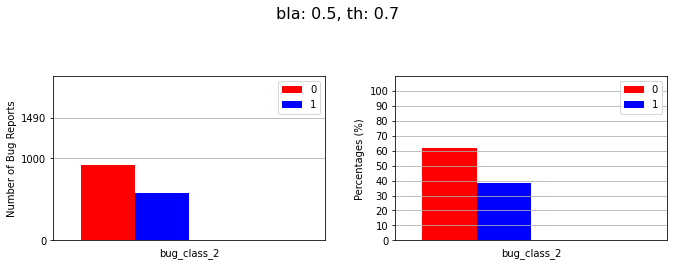

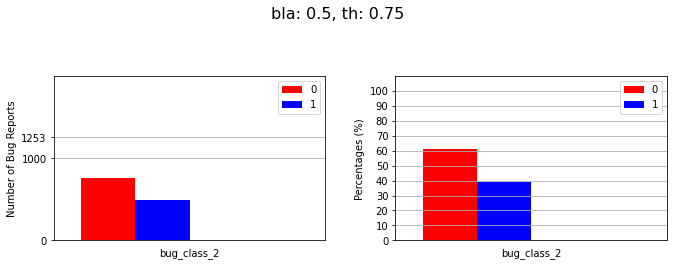

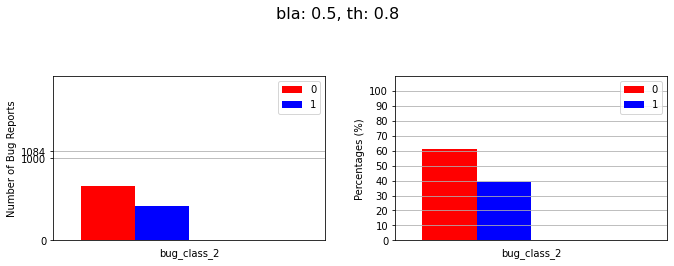

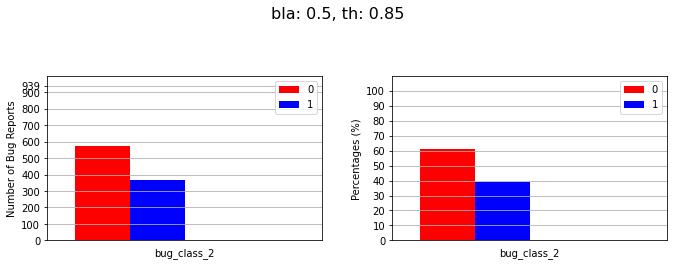

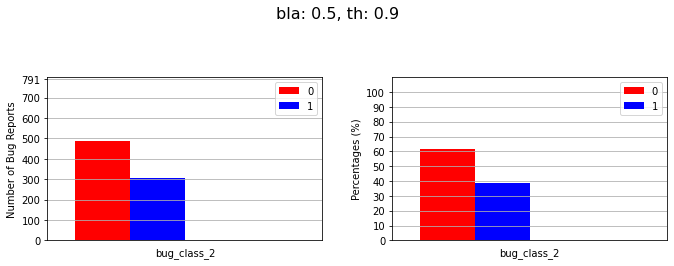

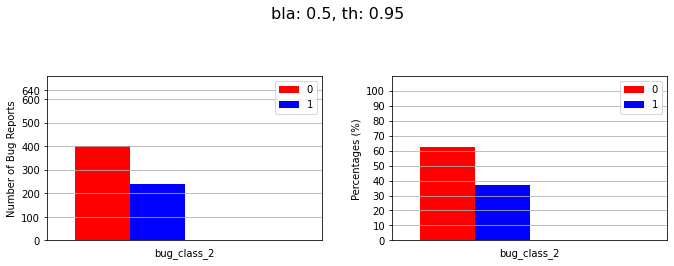

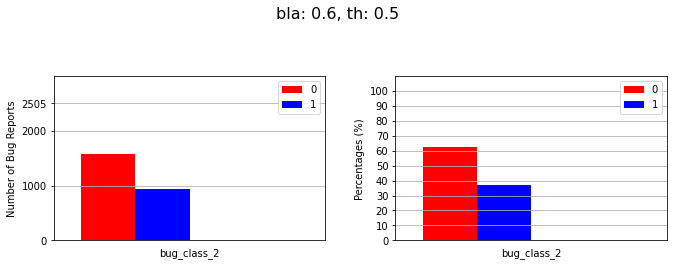

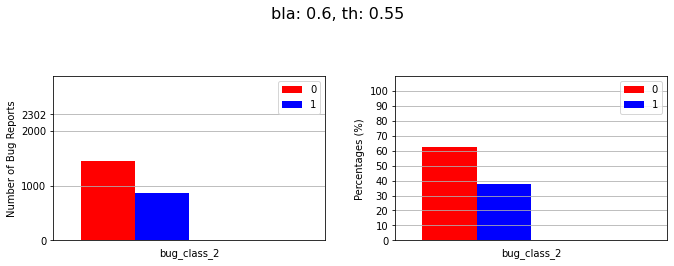

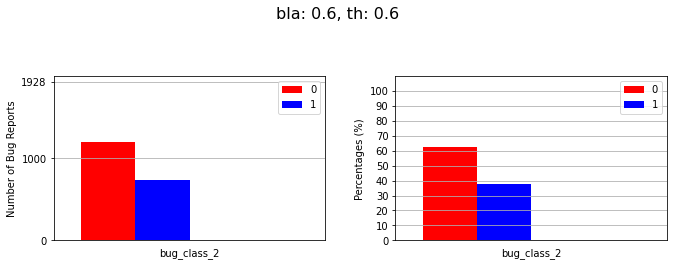

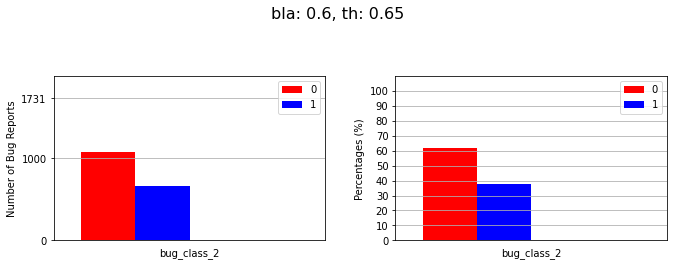

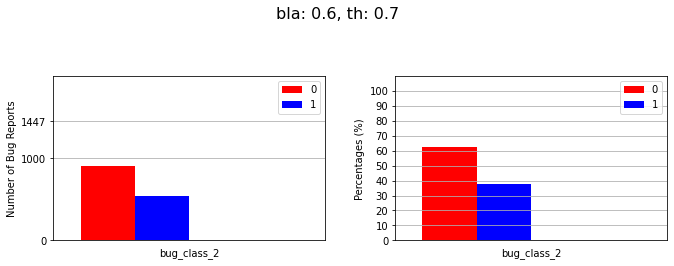

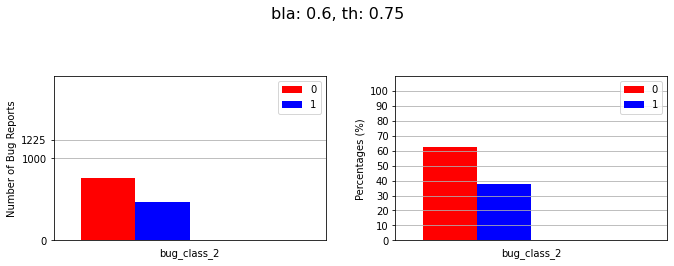

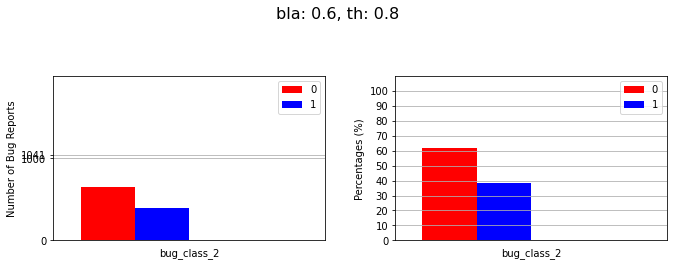

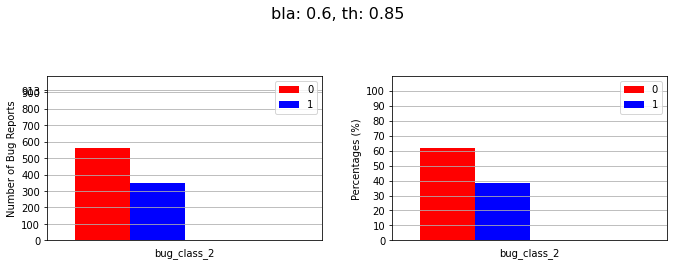

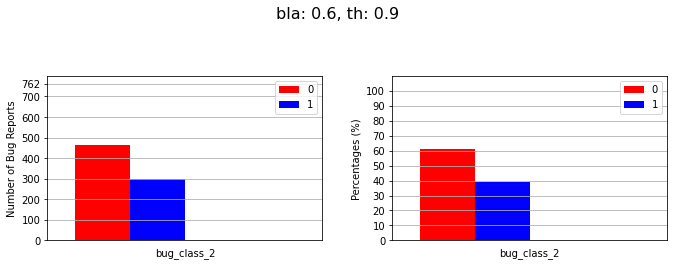

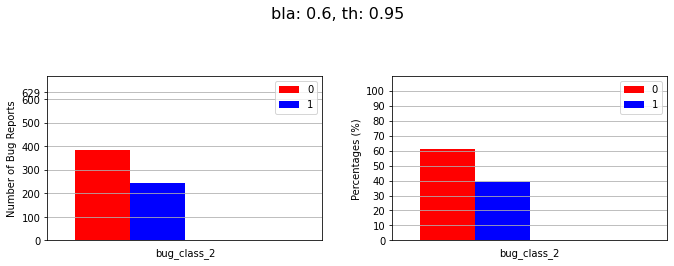

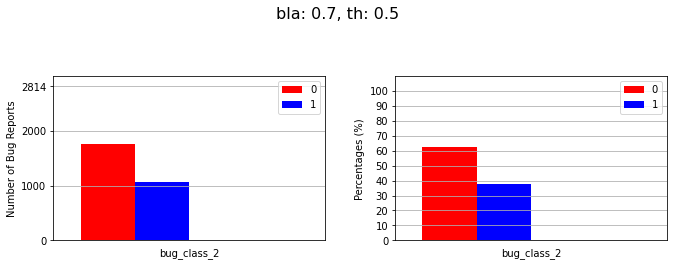

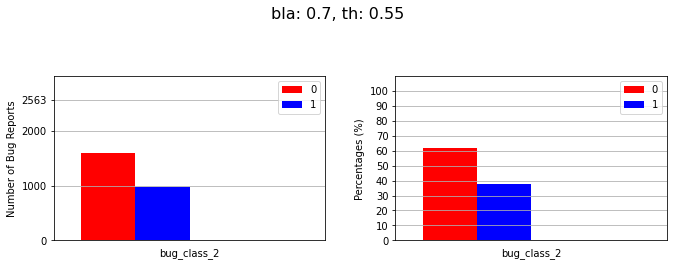

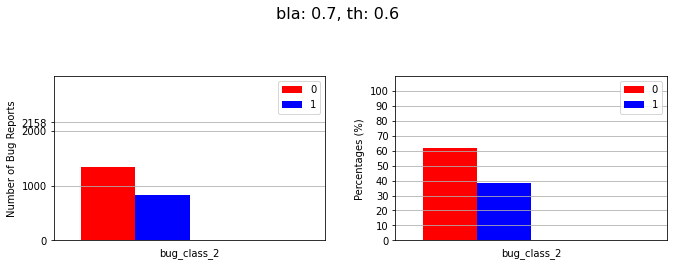

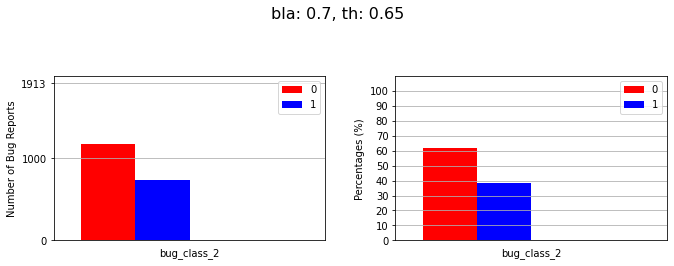

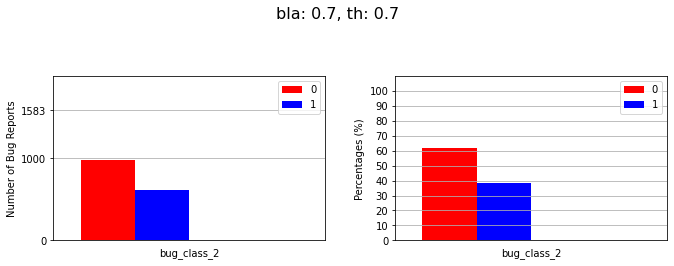

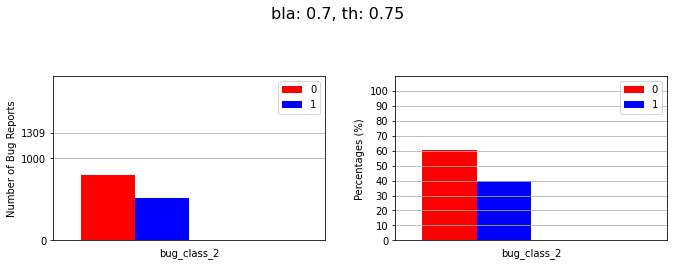

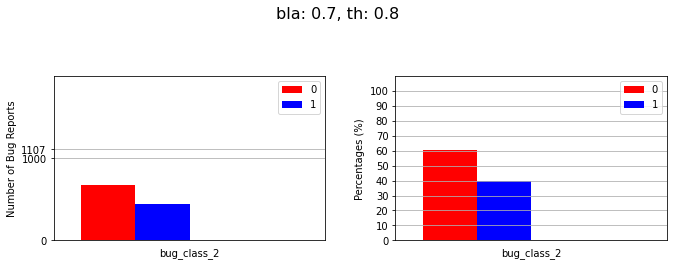

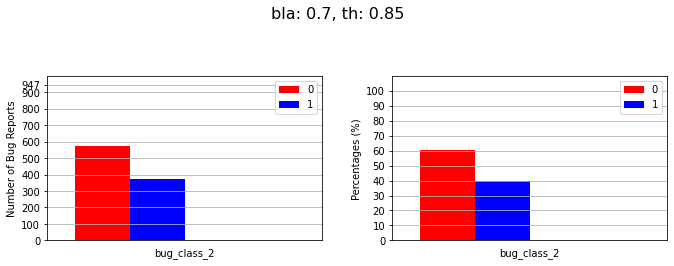

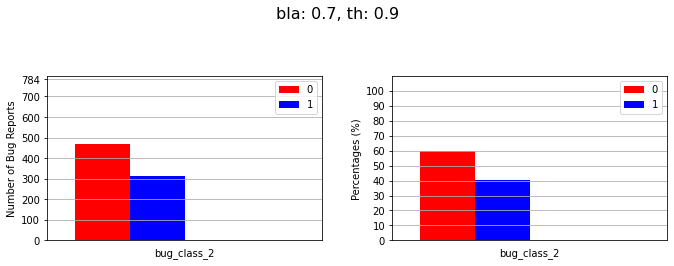

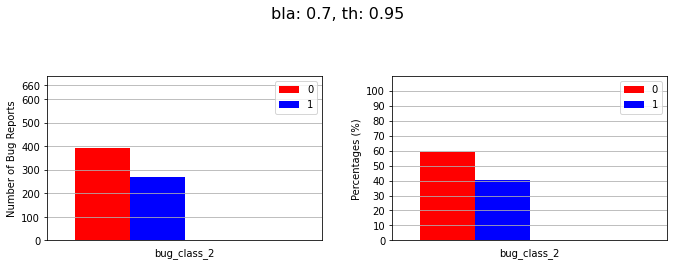

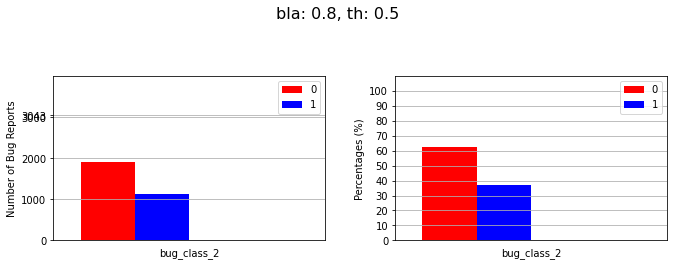

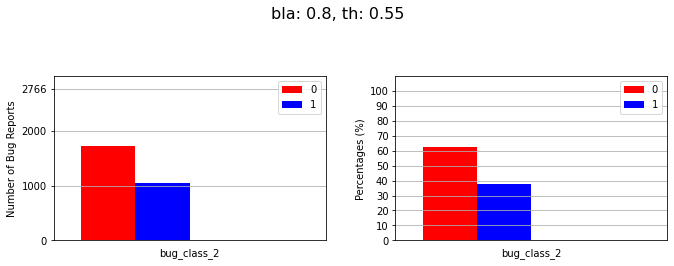

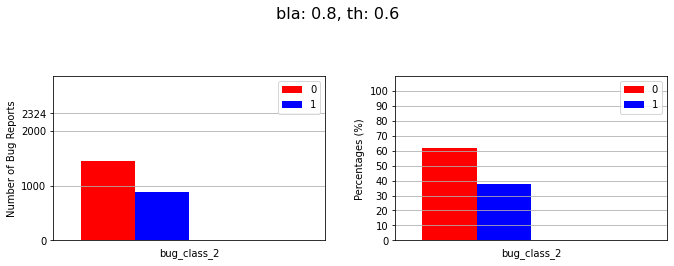

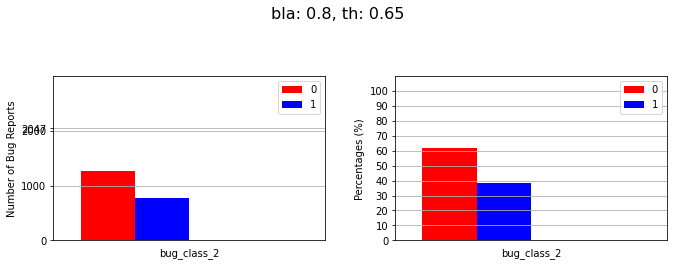

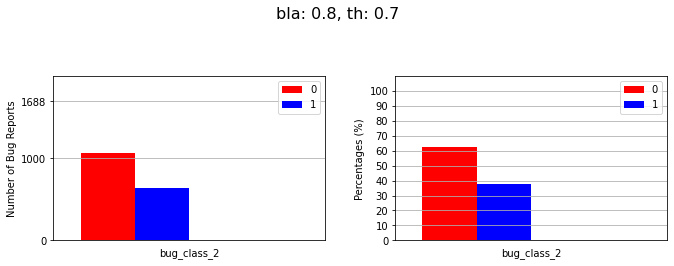

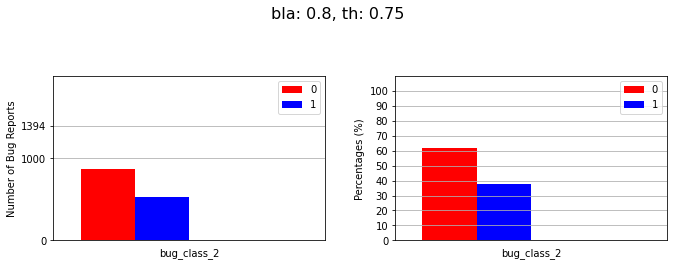

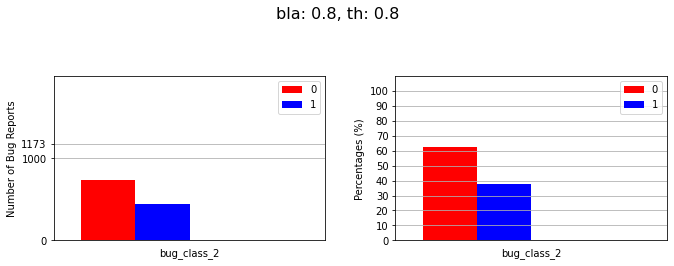

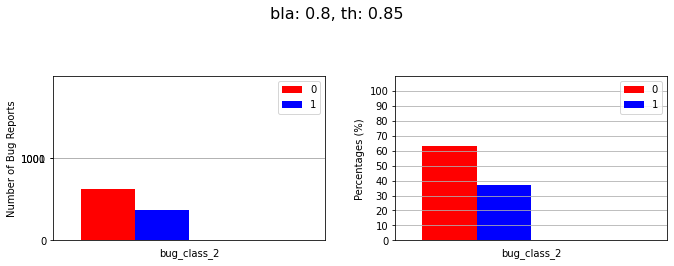

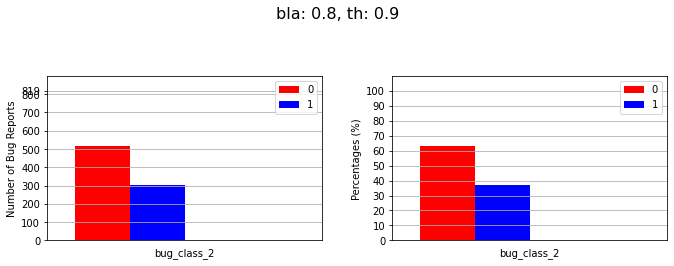

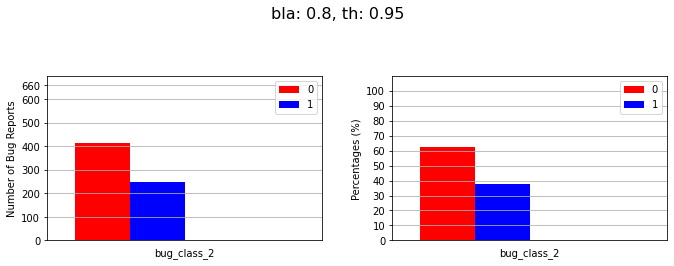

In [34]:
cddd.plotm(
    df_main_bug_preds, 
    bpfd_data.df_data_bug_preds)

In [35]:
cddd.df_data_bug_class_distribution

{0.4: {0.5: {'bug_class_num': {'bug_class_2': {'0': 1316, '1': 813}},
   'bug_class_per': {'bug_class_2': {'0': 61.81305777360263,
     '1': 38.18694222639737}},
   'bug_class_ratio': {'bug_class_2': {'0/1': 1.6186961869618697}}},
  0.55: {'bug_class_num': {'bug_class_2': {'0': 1214, '1': 767}},
   'bug_class_per': {'bug_class_2': {'0': 61.282180716809684,
     '1': 38.71781928319031}},
   'bug_class_ratio': {'bug_class_2': {'0/1': 1.5827900912646675}}},
  0.6: {'bug_class_num': {'bug_class_2': {'0': 1043, '1': 677}},
   'bug_class_per': {'bug_class_2': {'0': 60.63953488372093,
     '1': 39.36046511627907}},
   'bug_class_ratio': {'bug_class_2': {'0/1': 1.5406203840472674}}},
  0.65: {'bug_class_num': {'bug_class_2': {'0': 932, '1': 611}},
   'bug_class_per': {'bug_class_2': {'0': 60.40181464679196,
     '1': 39.59818535320804}},
   'bug_class_ratio': {'bug_class_2': {'0/1': 1.525368248772504}}},
  0.7: {'bug_class_num': {'bug_class_2': {'0': 814, '1': 519}},
   'bug_class_per': {'bug_

# MyConfusionMatrix

In [36]:
class MyConfusionMatrix():
    def __init__(self, num_classes):
        # rows: actual, columns: prediction
        self.confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    
    
    def update(self, y, yhat_indices):
        for actual, pred in zip(y, yhat_indices):
            self.confusion_matrix[actual, pred] += 1
    
    
    def calc_accuracy(self):
        diagon = self.confusion_matrix.diagonal()
        # accuracy
        total_samples = self.confusion_matrix.sum()
        total_corrects = diagon.sum()
        accuracy = 100 * (total_corrects / total_samples)
        
        # accuracy per class
        # sum(1): 1 referes to sum for each row
        samples_per_class = self.confusion_matrix.sum(1)
        accuracy_per_class = 100 * (np.divide(diagon, samples_per_class))
        
        return accuracy, accuracy_per_class.tolist()
    
    
    def get_cf(self):
        return self.confusion_matrix.tolist()

# CalcAcc

In [37]:
class CalcAcc():
    
    def __init__(self, df_main_bug_preds, threshold, bug_localization_accuracy, num_bugc2_classes):
        self.confusion_matrix = {}
        self.mycf = {}
        
        self.df_main_bug_preds = df_main_bug_preds
        self.threshold = threshold
        self.bla = bug_localization_accuracy
        
        self.samples_num = {}
        self.num_true = {} # {"0.50": {"simple": 100, "bc_2": 200, "bc_3":200, "bc_4":200}, ...}
        self.accuracy = {} # {"0.50": {"simple": 92.0, "bc_2": 100, "bc_3":100, "bc_4":100}, ...}
        self.brIDs_num = {}
        
        for bla in bug_localization_accuracy:
            self.samples_num[bla] = {}
            self.num_true[bla] = {}
            self.accuracy[bla] = {}
            self.brIDs_num[bla] = {}
            #--
            self.confusion_matrix[bla] = {}
            self.mycf[bla] = {}
            
            for th in threshold:
                self.num_true[bla][th] = {
                    "simple": 0, 
                    "bc_2": 0,
                }
            
                # bc: bug class
                self.accuracy[bla][th] = {
                    "simple": None, 
                    "bc_2": None, 
                }
                
                self.mycf[bla][th] = {}
                self.confusion_matrix[bla][th] = MyConfusionMatrix(num_bugc2_classes)
    
    
    # ================== simple ==================
    
    def simple(self, df_data_pred_filtered):
        for i, bla in enumerate(self.bla):
            for j, th in enumerate(self.threshold):
                df_data_pred_filtered[bla][j].apply(lambda row: self.sub_simple_(row, bla, th), axis=1)
                self.samples_num[bla][th] = len(df_data_pred_filtered[bla][j])
                print(bla, th, self.samples_num[bla][th])
                self.accuracy[bla][th]["simple"] = (self.num_true[bla][th]["simple"] / self.samples_num[bla][th]) * 100
    
    
    def sub_simple_(self, row, bla, th):
        tem = row.tail(1).item()
        if row["label"] == tem:
            self.num_true[bla][th]["simple"] += 1
    
    
    # =============================================
    #                   bug class
    # =============================================
    
    def bug_class(self, df_data_bug_preds):
        for i, bla in enumerate(self.bla):
            for j, th in enumerate(self.threshold):
                self.brIDs_num[bla][th] = len(df_data_bug_preds[bla][j])
                df_data_bug_preds[bla][j].apply(lambda row: self.sub_bug_class_(row, bla, th), axis=1)
                
                
                my_accuracy, acc_per = self.confusion_matrix[bla][th].calc_accuracy()
                self.accuracy[bla][th]["bc_2"] = my_accuracy
                # ----
                
                self.mycf[bla][th]["confusion_matrix"] = self.confusion_matrix[bla][th].get_cf()
                self.mycf[bla][th]["acc_per_class"] = acc_per
    
    
    def sub_bug_class_(self, row, bla, th):
        temp = self.df_main_bug_preds[(self.df_main_bug_preds["bug_report_id"] == row["bug_report_id"])]
        
        if row["bug_class_2"] == temp["bug_class_2"].item():
            self.num_true[bla][th]["bc_2"] += 1
        
        # confusion_matrix.update(y, yhat_indices)
        self.confusion_matrix[bla][th].update([temp["bug_class_2"].item()], [row["bug_class_2"]])

## obj

In [38]:
ca = CalcAcc(df_main_bug_preds, knn_accuracy_threshold, bug_localization_accuracy, 2)
ca.simple(datp_data.df_data_pred_filtered)
ca.bug_class(bpfd_data.df_data_bug_preds)

0.4 0.5 5801
0.4 0.55 5259
0.4 0.6 4359
0.4 0.65 3787
0.4 0.7 3138
0.4 0.75 2540
0.4 0.8 2155
0.4 0.85 1834
0.4 0.9 1530
0.4 0.95 1277
0.5 0.5 6806
0.5 0.55 6146
0.5 0.6 5141
0.5 0.65 4501
0.5 0.7 3734
0.5 0.75 3051
0.5 0.8 2497
0.5 0.85 2102
0.5 0.9 1687
0.5 0.95 1332
0.6 0.5 7361
0.6 0.55 6617
0.6 0.6 5381
0.6 0.65 4757
0.6 0.7 3900
0.6 0.75 3234
0.6 0.8 2624
0.6 0.85 2187
0.6 0.9 1756
0.6 0.95 1416
0.7 0.5 8600
0.7 0.55 7689
0.7 0.6 6371
0.7 0.65 5570
0.7 0.7 4541
0.7 0.75 3686
0.7 0.8 3064
0.7 0.85 2576
0.7 0.9 2087
0.7 0.95 1690
0.8 0.5 9534
0.8 0.55 8498
0.8 0.6 6963
0.8 0.65 6023
0.8 0.7 4877
0.8 0.75 3952
0.8 0.8 3256
0.8 0.85 2712
0.8 0.9 2124
0.8 0.95 1728


In [39]:
ca.accuracy

{0.4: {0.5: {'bc_2': 60.21606387975575, 'simple': 54.680227546974656},
  0.55: {'bc_2': 60.272589601211514, 'simple': 55.200608480699756},
  0.6: {'bc_2': 59.94186046511628, 'simple': 56.73319568708419},
  0.65: {'bc_2': 59.494491250810114, 'simple': 57.72379191972538},
  0.7: {'bc_2': 59.489872468117035, 'simple': 58.73167622689611},
  0.75: {'bc_2': 59.2788038698329, 'simple': 59.881889763779526},
  0.8: {'bc_2': 59.285004965243296, 'simple': 60.603248259860784},
  0.85: {'bc_2': 59.0, 'simple': 61.17775354416576},
  0.9: {'bc_2': 58.97771952817824, 'simple': 62.745098039215684},
  0.95: {'bc_2': 59.133126934984524, 'simple': 64.9177760375881}},
 0.5: {0.5: {'bc_2': 60.148514851485146, 'simple': 55.06905671466353},
  0.55: {'bc_2': 60.08888888888889, 'simple': 55.35307517084283},
  0.6: {'bc_2': 59.85663082437276, 'simple': 56.42871036763276},
  0.65: {'bc_2': 59.69125214408233, 'simple': 57.47611641857365},
  0.7: {'bc_2': 60.0, 'simple': 59.02517407605785},
  0.75: {'bc_2': 59.7765

In [40]:
ca.mycf

{0.4: {0.5: {'acc_per_class': [89.05775075987842, 13.530135301353013],
   'confusion_matrix': [[1172, 144], [703, 110]]},
  0.55: {'acc_per_class': [89.86820428336078, 13.428943937418513],
   'confusion_matrix': [[1091, 123], [664, 103]]},
  0.6: {'acc_per_class': [90.79578139980825, 12.40768094534712],
   'confusion_matrix': [[947, 96], [593, 84]]},
  0.65: {'acc_per_class': [91.09442060085837, 11.292962356792144],
   'confusion_matrix': [[849, 83], [542, 69]]},
  0.7: {'acc_per_class': [91.52334152334153, 9.248554913294797],
   'confusion_matrix': [[745, 69], [471, 48]]},
  0.75: {'acc_per_class': [91.75108538350217, 8.968609865470851],
   'confusion_matrix': [[634, 57], [406, 40]]},
  0.8: {'acc_per_class': [91.85667752442997, 8.396946564885496],
   'confusion_matrix': [[564, 50], [360, 33]]},
  0.85: {'acc_per_class': [91.77330895795247, 8.21529745042493],
   'confusion_matrix': [[502, 45], [324, 29]]},
  0.9: {'acc_per_class': [93.18681318681318, 8.441558441558442],
   'confusion_

In [41]:
bpfd_data.df_data_bug_preds

{0.4: [      bug_report_id  bug_class_2
  0             41778            0
  1             41802            0
  2             41805            0
  3             41808            0
  4             41814            0
  ...             ...          ...
  2124          53786            1
  2125          53831            0
  2126          53841            0
  2127          53854            0
  2128          53862            1
  
  [2129 rows x 2 columns],       bug_report_id  bug_class_2
  0             41778            0
  1             41802            0
  2             41805            0
  3             41808            0
  4             41818            0
  ...             ...          ...
  1976          53786            1
  1977          53831            0
  1978          53841            0
  1979          53854            0
  1980          53862            1
  
  [1981 rows x 2 columns],       bug_report_id  bug_class_2
  0             41778            0
  1             41802        

# Save results

In [42]:
def save_to_file_results(
    dataset_name, 
    preprocessing_params, 
    bug_localization_accuracy, 
    knn_model_params, 
    knn_accuracy_threshold, 

    samples_num, 
    brIDs_num, 

    samples_num_pred, 
    brIDs_num_pred, 

    df_data_bug_class_distribution,
    accuracies, 
    
    cf,
    
    result_path):
    
    tempStructure = {
        "dataset":                        dataset_name, 
        "preprocessing_params":           preprocessing_params, 
        "bug_localization_accuracy":      bug_localization_accuracy, 
        "knn_model_params":               knn_model_params,
        "knn_accuracy_threshold":         knn_accuracy_threshold,
        
        "samples_num":                    samples_num,
        "brIDs_num":                      brIDs_num,
        
        "samples_num_pred":               samples_num_pred,
        "brIDs_num_pred":                 brIDs_num_pred,
        
        "df_data_bug_class_distribution": df_data_bug_class_distribution,
        "accuracies":                     accuracies, 
        
        "confusion_matrix":               cf,
        
    }

    with open(result_path, "w") as fout:
        json.dump(tempStructure, fout)

## call

In [43]:
save_to_file_results(
    dataset_file_name, 
    preprocessing_params, 
    bug_localization_accuracy, 
    knn_model_params, 
    knn_accuracy_threshold, 

    len(df_data_pred[0.8]), 
    brIDs_num, 
    
    ca.samples_num, 
    ca.brIDs_num, 

    cddd.df_data_bug_class_distribution,
    ca.accuracy, 
    
    ca.mycf,
    
    mypaths["output"]["performance"]
)